In [1]:
# --- Optional: installs (uncomment if needed) ---
%pip install --quiet pillow numpy pandas pyarrow matplotlib tqdm torchvision torch
# If you plan to do the MongoDB extension:
%pip install --quiet pymongo
# For FAISS/Annoy extensions (advanced):
%pip install --quiet faiss-cpu annoy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 77.8 MB/s eta 0:00:00


In [2]:
import os, math, glob, hashlib, pathlib, io
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

# Deep features (optional but recommended)
import torch
from tqdm import tqdm

try:
    import torchvision
    from torchvision import transforms
except Exception as e:
    torchvision = None
    transforms = None
    print("torchvision not available, deep features will be skipped. Fallback: color histogram. Error:", e)

# ---------- Config ----------
DATA_DIR = "/content/drive/MyDrive/imageDataset"          # put your images here (recursively)
EMBEDDINGS_PATH = "./embeddings.parquet"
EMBEDDING_MODEL = "resnet50"        # options: 'resnet50' or 'hist' (color histogram fallback)
IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".bmp"}

# Auto-select device
if torch.cuda.is_available():
    DEVICE = "cuda"
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    DEVICE = "mps"  # Apple Silicon
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")
print(f"Images dir: {os.path.abspath(DATA_DIR)}")

Using device: cpu
Images dir: /content/drive/MyDrive/imageDataset


In [4]:
def list_images(root: str) -> List[str]:
    paths = []
    root = os.path.expanduser(root)
    for ext in IMAGE_EXTS:
        paths.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
    paths = sorted(set(paths))
    return paths

def sha256_of_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def load_image(path: str, max_size: int = 512) -> Image.Image:
    img = Image.open(path).convert("RGB")
    # quick thumbnail to bound max side
    img.thumbnail((max_size, max_size))
    return img

def show_image_grid(paths: List[str], titles: List[str] = None, cols: int = 5, figsize: Tuple[int,int] = (12, 8)):
    if not paths:
        print("No images to display.")
        return
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=figsize)
    for i, p in enumerate(paths):
        plt.subplot(rows, cols, i+1)
        try:
            img = load_image(p, max_size=512)
            plt.imshow(img)
        except Exception as e:
            plt.text(0.1, 0.5, f"Failed to load\n{os.path.basename(p)}\n{e}")
        plt.axis("off")
        if titles and i < len(titles):
            plt.title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

In [5]:

@dataclass
class EmbeddingResult:
    path: str
    sha256: str
    embedding: np.ndarray

def get_resnet50_extractor():
    if torchvision is None:
        return None, None

    # Use torchvision 0.15+ API for weights; fallback if older
    weights = None
    try:
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
        model = torchvision.models.resnet50(weights=weights)
        preprocess = weights.transforms()
    except Exception:
        # Older API
        model = torchvision.models.resnet50(pretrained=True)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # Remove the classification head to get a 2048-dim feature
    model.fc = torch.nn.Identity()
    model.eval()
    model.to(DEVICE)

    @torch.no_grad()
    def embed_one(img: Image.Image) -> np.ndarray:
        t = preprocess(img).unsqueeze(0).to(DEVICE)
        feats = model(t)  # [1, 2048]
        v = feats.cpu().numpy().astype("float32")[0]
        # L2 normalize for cosine
        v = v / (np.linalg.norm(v) + 1e-12)
        return v

    return model, embed_one

def embed_histogram(img: Image.Image, bins_per_channel: int = 8) -> np.ndarray:
    # HSV histogram (8x8x8 = 512-dim)
    hsv = img.convert("HSV")
    arr = np.array(hsv)
    hist = []
    for ch in range(3):
        h, _ = np.histogram(arr[..., ch], bins=bins_per_channel, range=(0, 256), density=True)
        hist.append(h)
    v = np.concatenate(hist).astype("float32")
    v = v / (np.linalg.norm(v) + 1e-12)
    return v

In [6]:
def build_embeddings(paths: List[str], method: str = EMBEDDING_MODEL) -> List[EmbeddingResult]:
    results = []
    embed_one = None

    if method == "resnet50":
        model, embed_one = get_resnet50_extractor()
        if embed_one is None:
            print("torchvision not available. Falling back to 'hist'.")
            method = "hist"

    for p in tqdm(paths, desc=f"Embedding ({method})"):
        try:
            img = load_image(p, max_size=1024 if method=='resnet50' else 512)
            if method == "resnet50":
                v = embed_one(img)
            else:
                v = embed_histogram(img)
            results.append(EmbeddingResult(path=p, sha256=sha256_of_file(p), embedding=v))
        except Exception as e:
            print("Failed:", p, e)
    return results


In [7]:
image_paths = list_images(DATA_DIR)
print(f"Found {len(image_paths)} images.")

embeds = build_embeddings(image_paths, method=EMBEDDING_MODEL)

# Pack into a DataFrame
if embeds:
    dim = embeds[0].embedding.shape[0]
else:
    dim = 0
df = pd.DataFrame({
    "path": [e.path for e in embeds],
    "sha256": [e.sha256 for e in embeds],
    "embedding": [e.embedding.tolist() for e in embeds],
    "dim": [dim for _ in embeds],
})
print(df.head())

# Save
if len(df):
    df.to_parquet(EMBEDDINGS_PATH, index=False)
    print(f"Saved embeddings -> {EMBEDDINGS_PATH} (n={len(df)})")
else:
    print("No embeddings to save. Did you place images in ./data/images ?")

Found 24 images.
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]
Embedding (resnet50): 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]

                                               path  \
0    /content/drive/MyDrive/imageDataset/apple.jpeg   
1    /content/drive/MyDrive/imageDataset/babar.jpeg   
2  /content/drive/MyDrive/imageDataset/buttler.jpeg   
3      /content/drive/MyDrive/imageDataset/cat.jpeg   
4    /content/drive/MyDrive/imageDataset/chair.jpeg   

                                              sha256  \
0  3c01ef1657d0cc01110f5eeff5c60b4eab936dbc044748...   
1  2f831a8b2b15d49069e7aa50f2a612a3bd74517180b520...   
2  96bd054df33fb0042312f8db9d7a70e09b9731014003e2...   
3  0c5043c8cf7432876f1126cb7e12ebe36863fe5f57a72e...   
4  0d67c1b82619aa2163df8b91fe2da4d0f0ca23907ba826...   

                                           embedding   dim  
0  [0.0, 0.008244217373430729, 0.0022390675731003...  2048  
1  [0.010606913827359676, 0.002794085070490837, 0...  2048  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00322974...  2048  
3  [0.0, 0.0072607542388141155, 0.005729577504098...  2048  
4  [0.0, 0.0, 0.42307877540

In [10]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12))

def search_topk(query_vec: np.ndarray, matrix: np.ndarray, k: int = 10) -> List[Tuple[int, float]]:
    # Returns list of (index, score) sorted by score desc
    sims = matrix @ query_vec / (np.linalg.norm(matrix, axis=1) * (np.linalg.norm(query_vec) + 1e-12))
    idxs = np.argpartition(-sims, min(k, len(sims)-1))[:k]
    idxs = idxs[np.argsort(-sims[idxs])]
    return [(int(i), float(sims[i])) for i in idxs]

# Materialize the matrix (n, d)
if len(df):
    M = np.vstack(df["embedding"].apply(lambda x: np.array(x, dtype="float32")).values)  # shape: (n, d)
    print("Embedding matrix:", M.shape)
else:
    M = np.zeros((0,0), dtype="float32")

Embedding matrix: (24, 2048)


In [26]:
# Choose a query image from the dataset:
if len(image_paths) >= 1:
    QUERY_IMAGE = "/content/lion1.jpeg"
else:
    QUERY_IMAGE = "/content/m1.jpeg"  # <- put a path string here like "./data/images/myphoto.jpg"

print("Query image:", QUERY_IMAGE)

Query image: /content/lion1.jpeg


Top-K results (index, cosine): [(11, 0.6886117458343506), (7, 0.2821584939956665), (8, 0.19903108477592468), (14, 0.17123658955097198), (10, 0.16368794441223145)]

Query preview:


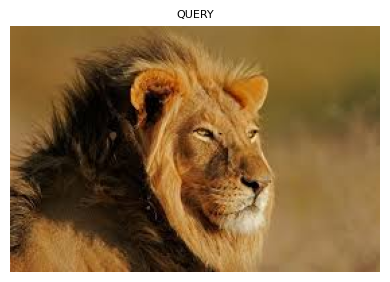

Results:


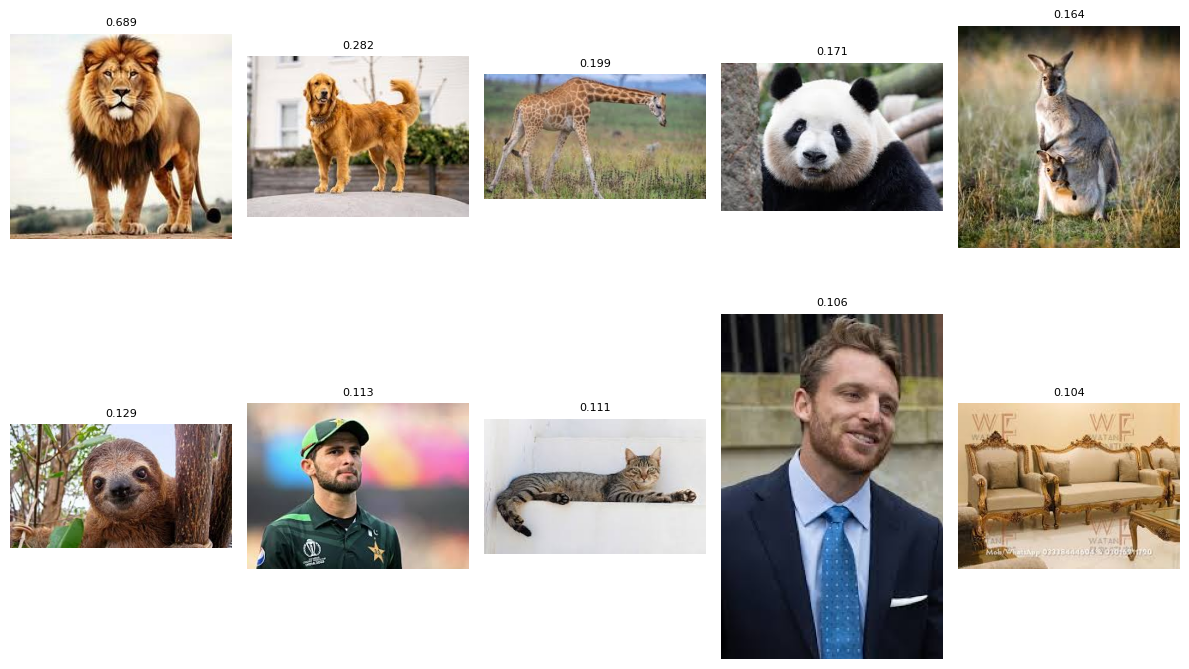

In [27]:
def embed_query(path: str, method: str = EMBEDDING_MODEL) -> np.ndarray:
    if method == "resnet50":
        model, embed_one = get_resnet50_extractor()
        if embed_one is None:
            method = "hist"
    img = load_image(path, max_size=1024 if method=='resnet50' else 512)
    if method == "resnet50":
        _, embed_one = get_resnet50_extractor()
        v = embed_one(img)
    else:
        v = embed_histogram(img)
    return v.astype("float32")

if QUERY_IMAGE and os.path.exists(QUERY_IMAGE) and len(df):
    q = embed_query(QUERY_IMAGE, method=EMBEDDING_MODEL)
    topk = search_topk(q, M, k=10)
    print("Top-K results (index, cosine):", topk[:5])

    result_paths = [df.iloc[i]["path"] for i, _ in topk]
    result_scores = [f"{s:.3f}" for _, s in topk]

    print("\nQuery preview:")
    show_image_grid([QUERY_IMAGE], titles=["QUERY"], cols=1, figsize=(4,4))

    print("Results:")
    show_image_grid(result_paths, titles=result_scores, cols=5, figsize=(12, 8))
else:
    print("Set QUERY_IMAGE to an existing file and ensure embeddings were built.")
